# Detecção de discurso ofensivo (PT) — SVM calibrado com controle de threshold

Notebook gerado automaticamente. Contém:
- Carga/normalização de dados
- *Splits* estratificados (train/val/test)
- Pipeline TF-IDF (word+char) + LinearSVC com calibração sigmóide
- Varredura de *threshold* no **VAL** com piso de *recall* para a minoria
- Avaliação no **TEST** (métricas, *confusion matrix*)
- Histograma de probabilidades e análise de erro (Top-3 FNs/FPs)

In [ ]:
import os, json, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    precision_recall_fscore_support, classification_report,
    confusion_matrix, accuracy_score, f1_score
)

plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (6.5, 4.2)

LANG_COL  = "lang"
TEXT_COL  = "text"
LABEL_COL = "label"


In [4]:

URL_RE = re.compile(r"https?://\S+|www\.\S+")
USR_RE = re.compile(r"@\w+")
def normalize_text(s: str) -> str:
    s = str(s).lower()
    s = URL_RE.sub("__url__", s)
    s = USR_RE.sub("__user__", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def load_csv(path: str | Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    assert {TEXT_COL, LABEL_COL}.issubset(df.columns), "CSV must have text,label"
    df[LANG_COL] = df[LABEL_COL].astype(str).str.split("_").str[0]
    df = df.dropna(subset=[TEXT_COL, LABEL_COL]).reset_index(drop=True)
    return df

def filter_lang(df: pd.DataFrame, lang3: str) -> pd.DataFrame:
    return df[df[LANG_COL] == lang3].reset_index(drop=True)

@dataclass
class Splits:
    train: pd.DataFrame
    val: pd.DataFrame
    test: pd.DataFrame

def stratified_splits_lang(df: pd.DataFrame, test_size=0.15, val_size=0.15, seed=42) -> Splits:
    X = df[TEXT_COL]; y = df[LABEL_COL]
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y)
    rel_val = val_size / (1 - test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=1-rel_val, random_state=seed, stratify=y_temp)
    train = pd.DataFrame({TEXT_COL: X_train, LABEL_COL: y_train})
    val   = pd.DataFrame({TEXT_COL: X_val,   LABEL_COL: y_val})
    test  = pd.DataFrame({TEXT_COL: X_test,  LABEL_COL: y_test})
    return Splits(train, val, test)

def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
        "report": classification_report(y_true, y_pred, output_dict=True)
    }

def plot_confusion(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig = plt.figure(figsize=(5.5, 4.8))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=90)
    plt.yticks(ticks, labels)
    plt.tight_layout()
    plt.ylabel("True")
    plt.xlabel("Pred")
    plt.show()


In [ ]:
CSV_PATH      = "dataset.csv"
OUT_DIR       = Path(".")
LANG          = "por"
C             = 3.0
RECALL_FLOOR  = 0.6
WORD_MIN_DF   = 1
WORD_MAX_DF   = 0.9
CHAR_MIN_DF   = 1
CHAR_NG_MIN   = 3
CHAR_NG_MAX   = 7

OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Params:", dict(
    CSV_PATH=CSV_PATH, LANG=LANG, C=C, RECALL_FLOOR=RECALL_FLOOR,
    WORD_MIN_DF=WORD_MIN_DF, WORD_MAX_DF=WORD_MAX_DF,
    CHAR_MIN_DF=CHAR_MIN_DF, CHAR_NG=(CHAR_NG_MIN, CHAR_NG_MAX),
))


Params: {'CSV_PATH': 'dataset.csv', 'LANG': 'por', 'C': 3.0, 'RECALL_FLOOR': 0.6, 'WORD_MIN_DF': 1, 'WORD_MAX_DF': 0.9, 'CHAR_MIN_DF': 1, 'CHAR_NG': (3, 7)}


In [ ]:
df = load_csv(CSV_PATH)
df = df[df[TEXT_COL].astype(str).str.strip()!=""]
df[TEXT_COL] = df[TEXT_COL].map(normalize_text)

df_lang = filter_lang(df, LANG)
print("shape total/lang:", df.shape, df_lang.shape)
df_lang.head(3)

splits = stratified_splits_lang(df_lang, test_size=0.15, val_size=0.15, seed=42)
for name, part in [("train", splits.train), ("val", splits.val), ("test", splits.test)]:
    print(name, part.shape, "| class dist:")
    print(part[LABEL_COL].value_counts(normalize=True).round(3), "\n")

labels_sorted = sorted(df_lang[LABEL_COL].unique().tolist())
pos_label = [l for l in labels_sorted if "bully" in l][0]
neg_label = [l for l in labels_sorted if l != pos_label][0]
labels_sorted_bin = [neg_label, pos_label]
print("pos_label:", pos_label, "| neg_label:", neg_label)


shape total/lang: (279126, 3) (6723, 3)
train (5714, 2) | class dist:
label
por_nonbully    0.685
por_bully       0.315
Name: proportion, dtype: float64 

val (178, 2) | class dist:
label
por_nonbully    0.685
por_bully       0.315
Name: proportion, dtype: float64 

test (831, 2) | class dist:
label
por_nonbully    0.685
por_bully       0.315
Name: proportion, dtype: float64 

pos_label: por_bully | neg_label: por_nonbully


Dimensões: (279127, 2)

Colunas: ['text', 'label']

.dtypes:
 text     object
label    object
dtype: object

.head():


,text,label
0,@ZubearSays Any real nigga isn't letting this ...,eng_race
1,@MoradoSkittle @prolifejewess @DAConsult @Kell...,eng_neutral
2,"the only thing i wish, i wish a nigga would",eng_race
3,You saudias are not friends of Muslim idiots c...,eng_religion
4,@JaydenT2399 @TractorLaw @holmes_gael @erconge...,eng_religion
5,@areyalldizzy @soobroll wait its so bad………. th...,eng_race
6,A voting machine error in New Jersey flipped t...,eng_neutral
7,"@Leeo2680 @KeaweWong Now in President Jokowi, ...",eng_religion
8,@NaTuRaLbeautyME @Phil_Lewis_ Agreed @NaTuRaLb...,eng_race
9,"Linked in an email, 'Sarah, you're on a roll w...",eng_neutral



Valores ausentes por coluna:
text         0
label        0
lang         0
len_chars    0
len_words    0
has_url      0
has_user     0
has_hash     0
has_emoji    0
dtype: int64

Duplicatas (texto+label): 283 | Duplicatas (apenas texto): 850
Textos vazios: 1

Distribuição de labels (contagem):


label
eng_neutral      50000
tur_nonbully     38916
eng_sex          17000
eng_race         17000
eng_religion     15990
ger_bully        13779
ger_nonbully     13536
rus_nonbully      9667
tur_bully         9648
spa_nonbully      7365
ind_nonbully      7313
ita_nonbully      5997
chi_nonbully      5283
fre_bully         5085
rus_bully         4841
urd_bully         4841
fre_nonbully      4781
por_nonbully      4604
ind_bully         4539
kor_bully         3969
spa_bully         3815
urd_nonbully      3438
ita_bully         3218
kor_nonbully      3137
hin_neutral       3050
chi_bully         2783
ara_nonbully      2591
por_bully         2119
ara_bully         1570
ben_political     1205
ben_troll         1202
ben_neutral       1201
ben_threat        1201
ben_sexual        1201
hin_fake          1144
hin_hate           792
hin_offense        742
hin_defame         564
Name: count, dtype: int64


Distribuição de labels (proporção):


label
eng_neutral      0.179
tur_nonbully     0.139
eng_sex          0.061
eng_race         0.061
eng_religion     0.057
ger_bully        0.049
ger_nonbully     0.048
rus_nonbully     0.035
tur_bully        0.035
spa_nonbully     0.026
ind_nonbully     0.026
ita_nonbully     0.021
chi_nonbully     0.019
fre_bully        0.018
rus_bully        0.017
urd_bully        0.017
fre_nonbully     0.017
por_nonbully     0.016
ind_bully        0.016
kor_bully        0.014
spa_bully        0.014
urd_nonbully     0.012
ita_bully        0.012
kor_nonbully     0.011
hin_neutral      0.011
chi_bully        0.010
ara_nonbully     0.009
por_bully        0.008
ara_bully        0.006
ben_political    0.004
ben_troll        0.004
ben_neutral      0.004
ben_threat       0.004
ben_sexual       0.004
hin_fake         0.004
hin_hate         0.003
hin_offense      0.003
hin_defame       0.002
Name: proportion, dtype: float64


Distribuição de idiomas (contagem):


lang
eng    99990
tur    48564
ger    27315
rus    14508
ind    11852
spa    11180
fre     9866
ita     9215
urd     8279
chi     8066
kor     7106
por     6723
hin     6292
ben     6010
ara     4161
Name: count, dtype: int64

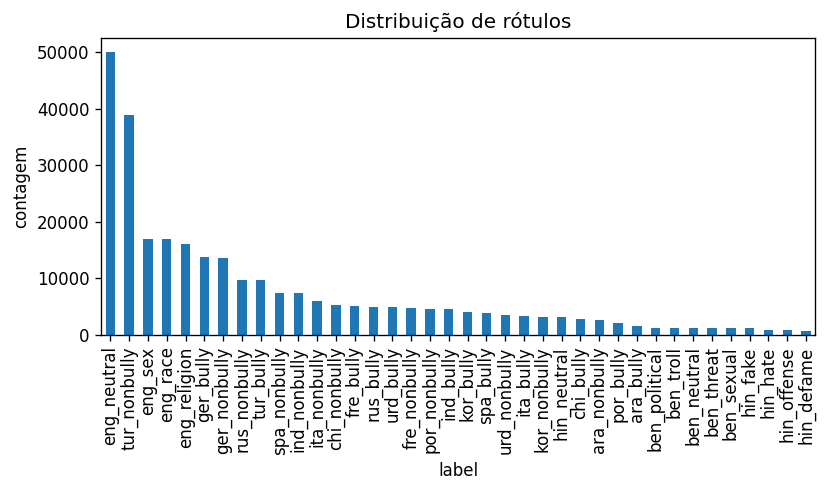

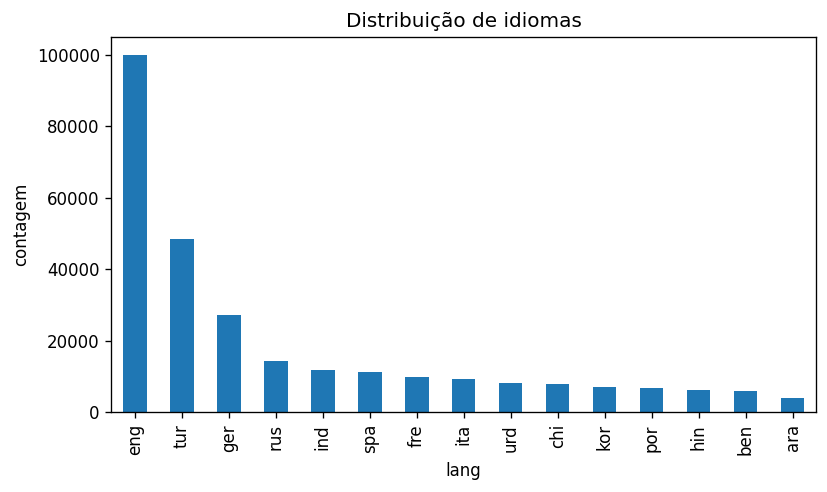


.describe() de comprimentos:


,len_chars,len_words
count,279127.00,279127.00
mean,125.94,20.00
std,125.71,19.44
min,1.00,0.00
10%,36.00,6.00
25%,56.00,9.00
50%,96.00,15.00
75%,163.00,26.00
90%,267.00,42.00
95%,301.00,50.00


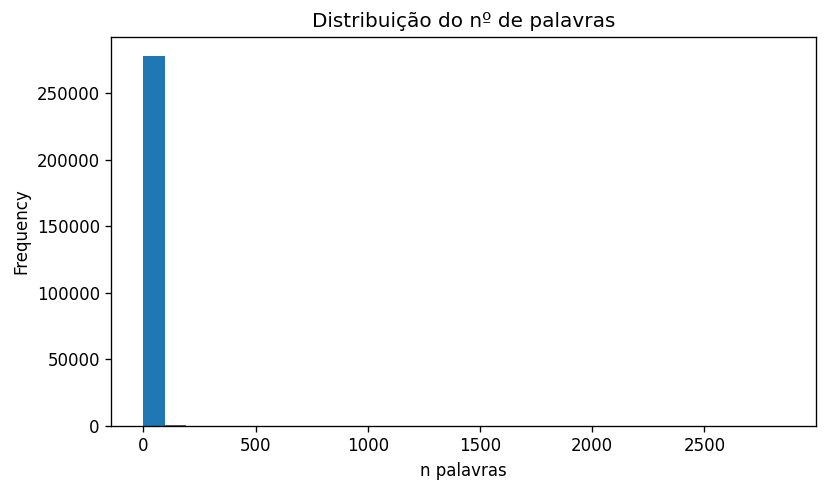

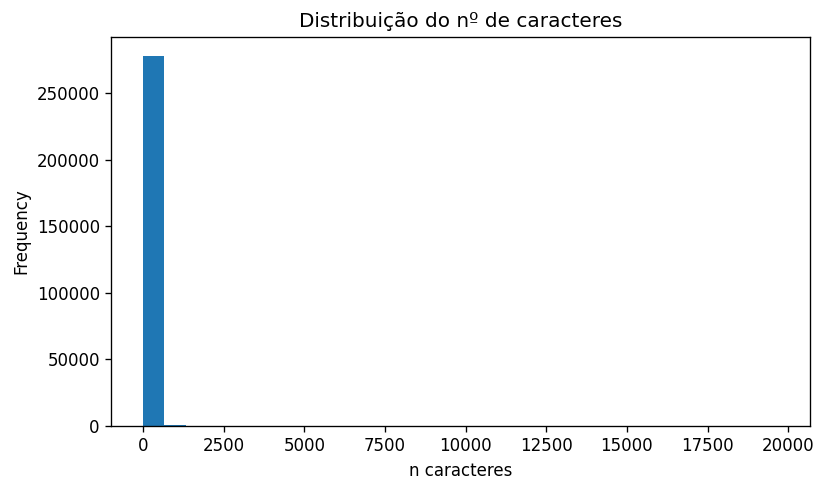

<Figure size 960x480 with 0 Axes>

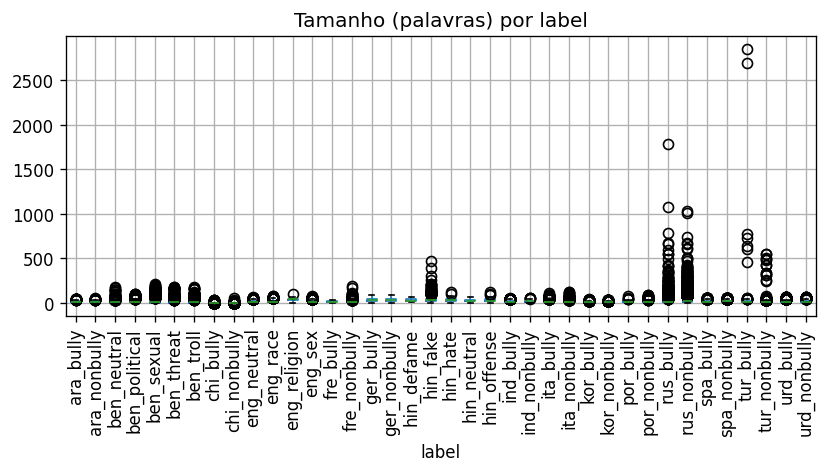


Sinais de mídia social/ruído:


,proporcao
has_url,0.102
has_user,0.254
has_hash,0.056
has_emoji,0.095


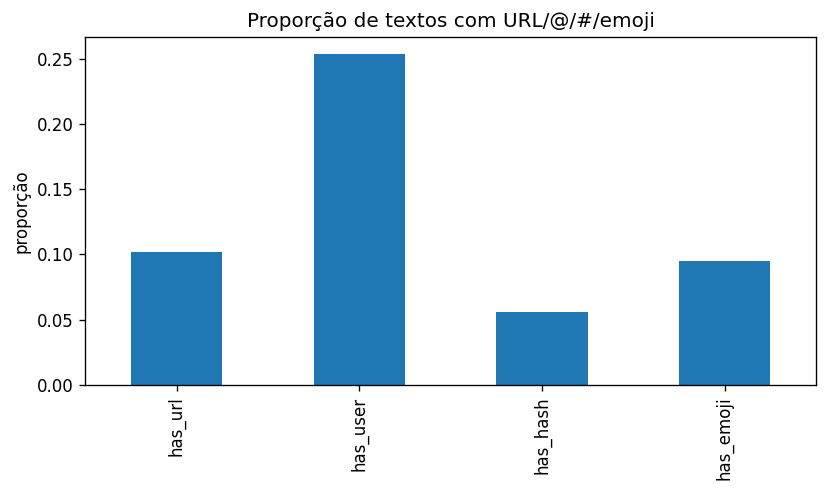


Resumo por idioma (n, média len_words, %URL, %@):


,n,mean_words,url,user
lang,,,,
ara,4161,12.06,0.00,0.00
ben,6010,17.40,0.00,0.00
chi,8066,1.55,0.00,0.00
eng,99990,21.33,0.25,0.52
fre,9866,13.94,0.00,0.30
ger,27315,33.95,0.03,0.00
hin,6292,30.28,0.44,0.35
ind,11852,17.24,0.00,0.00
ita,9215,15.53,0.00,0.00



Primeiros textos (n=5)


,text,label,len_words
0,@ZubearSays Any real nigga isn't letting this ...,eng_race,8
1,@MoradoSkittle @prolifejewess @DAConsult @Kell...,eng_neutral,22
2,"the only thing i wish, i wish a nigga would",eng_race,10
3,You saudias are not friends of Muslim idiots c...,eng_religion,10
4,@JaydenT2399 @TractorLaw @holmes_gael @erconge...,eng_religion,51



Exemplos da classe: eng_neutral (n=5)


,text,label,len_words
1,@MoradoSkittle @prolifejewess @DAConsult @Kell...,eng_neutral,22
6,A voting machine error in New Jersey flipped t...,eng_neutral,27
9,"Linked in an email, 'Sarah, you're on a roll w...",eng_neutral,27
10,Man Digs Galamsey Pit In His Room.. watch full...,eng_neutral,14
13,@abigailubechtel yay! I’ll get them when I go,eng_neutral,8



Exemplos da classe: tur_nonbully (n=5)


,text,label,len_words
176208,Yorum yapacam diye yapmayan yorumcu abii eşkıy...,tur_nonbully,11
176209,Oruçluyum zaman geçsin istiyorum ama haftasonu...,tur_nonbully,10
176211,@USER Başbuğ zamanında desen doğru idi şimdi i...,tur_nonbully,13
176212,"Apple, dünyanın en güvenli masaüstü işletim si...",tur_nonbully,33
176213,Her geçen gün biraz daha soğuyor geceler. Yokl...,tur_nonbully,27



Exemplos da classe: eng_sex (n=5)


,text,label,len_words
21,@deshay_aunyae bitch biggie irritating asf,eng_sex,5
25,@MenInBlazers He is a bitch. Plain and simple...,eng_sex,12
31,when things are fucked up i call my cousin cos...,eng_sex,18
32,@seafish1982 And when you feel like you're box...,eng_sex,22
33,Fuckin nasty ass oh I feel like I can’t pee bi...,eng_sex,15



Exemplos da classe: eng_race (n=5)


,text,label,len_words
0,@ZubearSays Any real nigga isn't letting this ...,eng_race,8
2,"the only thing i wish, i wish a nigga would",eng_race,10
5,@areyalldizzy @soobroll wait its so bad………. th...,eng_race,10
8,@NaTuRaLbeautyME @Phil_Lewis_ Agreed @NaTuRaLb...,eng_race,49
11,@bjorkdelgay @dijoni Rise above it! MANY of u...,eng_race,49



Vocabulário (token simples) ≈ 384303 termos


,ngram,freq
0,a,63892
1,the,62766
2,i,60921
3,t,53789
4,to,48626
5,in,41243
6,you,40387
7,user,40011
8,and,38900
9,co,31486


,ngram,freq
0,t co,31144
1,https t,30404
2,user user,16269
3,don t,7484
4,i m,7188
5,it s,6617
6,in the,4913
7,of the,4060
8,is a,3251
9,to be,3213


,ngram,freq
0,er,179222
1,en,160058
2,th,151503
3,the,110369
4,de,106726
5,he,88572
6,in,87843
7,ng,85740
8,ing,84636
9,nd,84065



Top-10 tokens por classe (preview):

== ara_bully ==


,ngram,freq
0,2005,1



== ara_nonbully ==


,ngram,freq



== ben_neutral ==


,ngram,freq
0,e0,28
1,a6,23
2,com,10
3,https,9
4,chowdhury,9
5,the,8
6,nurunnabi,8
7,shawon,8
8,mp,8
9,www,7



== ben_political ==


,ngram,freq
0,1971,1
1,24,1



== ben_sexual ==


,ngram,freq
0,_,12
1,6,7
2,com,7
3,trick,7
4,bd,7
5,all,7
6,sim,7
7,free,7
8,net,7
9,51,6



== ben_threat ==


,ngram,freq
0,angry,7
1,to,5
2,you,5
3,safa,5
4,kabir,5
5,bnp,4
6,_,4
7,it,3
8,the,3
9,on,3



== ben_troll ==


,ngram,freq
0,d,6
1,alom,6
2,hero,5
3,p,4
4,_,3
5,is,3
6,1,3
7,3,2
8,real,2
9,and,2



== chi_bully ==


,ngram,freq
0,username,80
1,gay,78
2,papi,37
3,2,34
4,metoo,28
5,t,28
6,1,24
7,3,18
8,les,18
9,b,15



== chi_nonbully ==


,ngram,freq
0,username,61
1,metoo,60
2,1,58
3,2,44
4,papi,43
5,me,32
6,too,31
7,3,25
8,10,24
9,po,23



== eng_neutral ==


,ngram,freq
0,t,27002
1,the,25278
2,i,22448
3,co,20231
4,https,19930
5,to,19798
6,a,15845
7,and,13478
8,you,13460
9,it,10874



== eng_race ==


,ngram,freq
0,nigga,12378
1,a,9379
2,the,8418
3,i,8361
4,you,7305
5,t,7029
6,to,6480
7,and,5207
8,that,5194
9,it,3996



== eng_religion ==


,ngram,freq
0,the,18898
1,and,13231
2,to,13113
3,of,11753
4,a,11423
5,you,11169
6,is,10132
7,in,9123
8,muslim,8124
9,t,7143



== eng_sex ==


,ngram,freq
0,bitch,15381
1,a,9490
2,i,9132
3,the,7265
4,you,7149
5,t,6326
6,to,6032
7,and,5425
8,that,4407
9,is,3845



== fre_bully ==


,ngram,freq
0,user,2805
1,de,2303
2,les,1671
3,est,1452
4,un,1349
5,la,1325
6,le,1266
7,url,1266
8,c,1092
9,l,1073



== fre_nonbully ==


,ngram,freq
0,de,1756
1,les,1242
2,est,1173
3,la,1154
4,the,1000
5,l,966
6,le,935
7,user,905
8,a,884
9,et,882



== ger_bully ==


,ngram,freq
0,die,15188
1,und,11279
2,der,10597
3,das,6688
4,ist,6394
5,nicht,6340
6,in,6074
7,zu,4602
8,es,4529
9,den,4462



== ger_nonbully ==


,ngram,freq
0,die,15730
1,und,11146
2,der,10676
3,das,7491
4,ist,6628
5,nicht,6608
6,in,6306
7,es,5026
8,zu,4762
9,den,4725



== hin_defame ==


,ngram,freq
0,_,84
1,rt,44
2,https,35
3,t,34
4,co,34
5,kanganateam,25
6,_pb_swain_,20
7,bjp,16
8,narendramodi,15
9,6,13



== hin_fake ==


,ngram,freq
0,_,123
1,5,37
2,2,29
3,1,28
4,15,27
5,19,23
6,https,22
7,10,19
8,3,17
9,2020,17



== hin_hate ==


,ngram,freq
0,_,163
1,rt,80
2,https,53
3,t,51
4,co,51
5,narendramodi,18
6,6,17
7,_pb_swain_,14
8,100,14
9,9,13



== hin_neutral ==


,ngram,freq
0,co,2932
1,https,2931
2,t,2931
3,via,137
4,navbharattimes,130
5,uppolice,110
6,live,103
7,2,98
8,19,94
9,policemedianews,90



== hin_offense ==


,ngram,freq
0,_,145
1,https,68
2,t,67
3,co,67
4,rt,64
5,sanjayazadsln,26
6,kanganateam,22
7,anuragkashyap72,20
8,narendramodi,20
9,rahulgandhi,16



== ind_bully ==


,ngram,freq
0,user,6709
1,xf0,1172
2,x9f,1167
3,x98,971
4,yg,861
5,n,624
6,di,578
7,itu,511
8,dan,485
9,cebong,462



== ind_nonbully ==


,ngram,freq
0,user,7899
1,dan,1983
2,di,1856
3,yg,1801
4,yang,1416
5,itu,1049
6,ini,1030
7,ada,936
8,n,919
9,xf0,768



== ita_bully ==


,ngram,freq
0,e,1387
1,che,1162
2,di,1155
3,a,1018
4,non,941
5,la,886
6,i,750
7,in,640
8,il,631
9,le,578



== ita_nonbully ==


,ngram,freq
0,di,1944
1,a,1681
2,e,1591
3,in,1556
4,che,1475
5,la,1409
6,non,1310
7,i,1270
8,il,1188
9,the,1050



== kor_bully ==


,ngram,freq
0,1,54
1,30,45
2,2,44
3,40,34
4,20,27
5,3,25
6,ooo,23
7,yg,22
8,10,21
9,5,16



== kor_nonbully ==


,ngram,freq
0,1,57
1,2,50
2,3,32
3,10,14
4,20,13
5,4,11
6,6,10
7,40,9
8,5,8
9,jyp,7



== por_bully ==


,ngram,freq
0,de,931
1,que,900
2,e,819
3,a,805
4,o,703
5,é,687
6,não,591
7,se,354
8,do,324
9,rt,316



== por_nonbully ==


,ngram,freq
0,o,1959
1,de,1921
2,a,1849
3,e,1771
4,que,1704
5,não,1108
6,é,1020
7,do,867
8,rt,767
9,_,763



== rus_bully ==


,ngram,freq
0,1,87
1,2,84
2,3,62
3,10,50
4,5,48
5,c,34
6,15,32
7,4,31
8,20,30
9,50,24



== rus_nonbully ==


,ngram,freq
0,2,469
1,5,427
2,3,391
3,1,380
4,10,308
5,4,285
6,20,187
7,100,180
8,6,172
9,30,150



== spa_bully ==


,ngram,freq
0,de,2910
1,que,2556
2,y,1905
3,a,1900
4,la,1799
5,no,1290
6,los,1116
7,en,1099
8,el,1093
9,es,968



== spa_nonbully ==


,ngram,freq
0,de,6423
1,que,4951
2,la,4369
3,y,3536
4,a,3327
5,el,2923
6,no,2783
7,en,2540
8,es,1907
9,los,1788



== tur_bully ==


,ngram,freq
0,n,6972
1,user,4846
2,m,3095
3,i,2905
4,k,2616
5,bu,2548
6,bir,2422
7,z,2303
8,de,2276
9,r,1602



== tur_nonbully ==


,ngram,freq
0,n,18292
1,user,16781
2,m,13777
3,i,9610
4,bir,9298
5,k,8542
6,de,8389
7,bu,6788
8,r,6105
9,z,6093



== urd_bully ==


,ngram,freq
0,hai,1304
1,k,1071
2,ki,968
3,to,960
4,ko,914
5,ho,678
6,ka,677
7,na,601
8,se,583
9,ha,561



== urd_nonbully ==


,ngram,freq
0,hai,1326
1,ki,1152
2,ko,816
3,k,740
4,ka,718
5,to,608
6,ho,516
7,se,472
8,ye,470
9,ke,450



Arquivos gerados em /home/vini/dev/nlp
- eda_labels_bar.png / eda_langs_bar.png / eda_len_* / eda_noise_bar.png
- eda_top_tokens.csv / eda_top_bigrams.csv / eda_top_char_trigrams.csv
- eda_summary.json


In [ ]:
from pathlib import Path
import re, math, json
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (7, 4.2)

df = pd.read_csv(CSV_PATH)
print("Dimensões:", df.shape)
print("\nColunas:", list(df.columns))
print("\n.dtypes:\n", df.dtypes)

print("\n.head():")
display(df.head(10))

assert {"text", "label"}.issubset(df.columns), "CSV deve ter colunas text,label"

df = df.dropna(subset=["text", "label"]).reset_index(drop=True)

df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(str)

df["lang"] = df["label"].str.split("_").str[0]

df["len_chars"] = df["text"].str.len()
df["len_words"] = df["text"].str.split().map(len)

URL_RE = re.compile(r"https?://\S+|www\.\S+")
USR_RE = re.compile(r"@\w+")
HASH_RE = re.compile(r"#\w+")
EMOJI_RE = re.compile(r"[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF"
                      r"\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]")

df["has_url"]   = df["text"].str.contains(URL_RE).fillna(False)
df["has_user"]  = df["text"].str.contains(USR_RE).fillna(False)
df["has_hash"]  = df["text"].str.contains(HASH_RE).fillna(False)
df["has_emoji"] = df["text"].str.contains(EMOJI_RE).fillna(False)

print("\nValores ausentes por coluna:")
print(df.isna().sum())

dup_rows = df.duplicated(subset=["text", "label"]).sum()
dup_text = df["text"].duplicated().sum()
print(f"\nDuplicatas (texto+label): {dup_rows} | Duplicatas (apenas texto): {dup_text}")

empty_text = (df["text"].str.strip()=="").sum()
print("Textos vazios:", empty_text)

print("\nDistribuição de labels (contagem):")
display(df["label"].value_counts())

print("\nDistribuição de labels (proporção):")
display(df["label"].value_counts(normalize=True).round(3))

print("\nDistribuição de idiomas (contagem):")
display(df["lang"].value_counts())

plt.figure()
df["label"].value_counts().sort_values(ascending=False).plot(kind="bar")
plt.title("Distribuição de rótulos")
plt.ylabel("contagem"); plt.tight_layout()
plt.savefig(OUT_DIR / "eda_labels_bar.png"); plt.show()

plt.figure()
df["lang"].value_counts().sort_values(ascending=False).plot(kind="bar")
plt.title("Distribuição de idiomas")
plt.ylabel("contagem"); plt.tight_layout()
plt.savefig(OUT_DIR / "eda_langs_bar.png"); plt.show()

print("\n.describe() de comprimentos:")
display(df[["len_chars","len_words"]].describe(percentiles=[.1,.25,.5,.75,.9,.95]).round(2))

plt.figure()
df["len_words"].plot(kind="hist", bins=30)
plt.title("Distribuição do nº de palavras"); plt.xlabel("n palavras"); plt.tight_layout()
plt.savefig(OUT_DIR / "eda_len_words_hist.png"); plt.show()

plt.figure()
df["len_chars"].plot(kind="hist", bins=30)
plt.title("Distribuição do nº de caracteres"); plt.xlabel("n caracteres"); plt.tight_layout()
plt.savefig(OUT_DIR / "eda_len_chars_hist.png"); plt.show()

plt.figure(figsize=(8,4))
df.boxplot(column="len_words", by="label", rot=90)
plt.suptitle(""); plt.title("Tamanho (palavras) por label"); plt.tight_layout()
plt.savefig(OUT_DIR / "eda_len_words_by_label_box.png"); plt.show()

print("\nSinais de mídia social/ruído:")
stats_noise = (
    df[["has_url","has_user","has_hash","has_emoji"]]
    .mean().rename("proporcao").to_frame().round(3)
)
display(stats_noise)

plt.figure()
stats_noise["proporcao"].plot(kind="bar")
plt.title("Proporção de textos com URL/@/#/emoji"); plt.ylabel("proporção"); plt.tight_layout()
plt.savefig(OUT_DIR / "eda_noise_bar.png"); plt.show()

print("\nResumo por idioma (n, média len_words, %URL, %@):")
by_lang = df.groupby("lang").agg(
    n=("text","count"),
    mean_words=("len_words","mean"),
    url=("has_url","mean"),
    user=("has_user","mean")
)
display(by_lang.round(2))

def show_samples(frame, title, n=5):
    print(f"\n{title} (n={n})")
    display(frame[["text","label","len_words"]].head(n))

show_samples(df, "Primeiros textos")
for lab in df["label"].value_counts().index[:4]:
    show_samples(df[df["label"]==lab], f"Exemplos da classe: {lab}")

TOKEN_RE = re.compile(r"[a-zA-ZÀ-ÖØ-öø-ÿ0-9_]+", re.UNICODE)

def simple_tokens(s: str):
    return TOKEN_RE.findall(s.lower())

def top_k(counter: Counter, k=30):
    return pd.DataFrame(counter.most_common(k), columns=["ngram","freq"])

all_tokens = Counter()
for t in df["text"]:
    all_tokens.update(simple_tokens(t))
vocab_size = len(all_tokens)
print(f"\nVocabulário (token simples) ≈ {vocab_size} termos")

top_tokens = top_k(all_tokens, 40)
display(top_tokens.head(20))
top_tokens.to_csv(OUT_DIR / "eda_top_tokens.csv", index=False)

def gen_bigrams(tokens):
    for i in range(len(tokens)-1):
        yield tokens[i] + " " + tokens[i+1]

bigrams = Counter()
for t in df["text"]:
    toks = simple_tokens(t)
    bigrams.update(gen_bigrams(toks))

top_bigrams = top_k(bigrams, 40)
display(top_bigrams.head(20))
top_bigrams.to_csv(OUT_DIR / "eda_top_bigrams.csv", index=False)

def char_ngrams(s: str, n=3):
    s = s.lower()
    return [s[i:i+n] for i in range(len(s)-n+1)]

char3 = Counter()
for t in df["text"]:
    char3.update(char_ngrams(t, 3))
top_char3 = top_k(char3, 40)
display(top_char3.head(20))
top_char3.to_csv(OUT_DIR / "eda_top_char_trigrams.csv", index=False)

per_label_tok = {}
for lab, grp in df.groupby("label"):
    c = Counter()
    for t in grp["text"]:
        c.update(simple_tokens(t))
    per_label_tok[lab] = top_k(c, 20)

print("\nTop-10 tokens por classe (preview):")
for lab, tab in per_label_tok.items():
    print(f"\n== {lab} ==")
    display(tab.head(10))

summary = {
    "n_rows": int(df.shape[0]),
    "n_cols": int(df.shape[1]),
    "labels_count": df["label"].value_counts().to_dict(),
    "labels_ratio": df["label"].value_counts(normalize=True).round(4).to_dict(),
    "langs_count": df["lang"].value_counts().to_dict(),
    "len_words_describe": df["len_words"].describe().to_dict(),
    "noise_ratio": stats_noise["proporcao"].round(4).to_dict(),
    "vocab_size": int(vocab_size),
}
with open(OUT_DIR / "eda_summary.json","w",encoding="utf-8") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print("\nArquivos gerados em", OUT_DIR.resolve())
print("- eda_labels_bar.png / eda_langs_bar.png / eda_len_* / eda_noise_bar.png")
print("- eda_top_tokens.csv / eda_top_bigrams.csv / eda_top_char_trigrams.csv")
print("- eda_summary.json")


In [ ]:

feats = FeatureUnion([
    ("word", TfidfVectorizer(
        analyzer="word", ngram_range=(1,2),
        min_df=WORD_MIN_DF, max_df=WORD_MAX_DF,
        sublinear_tf=True, strip_accents="unicode", lowercase=True)),
    ("char", TfidfVectorizer(
        analyzer="char_wb", ngram_range=(CHAR_NG_MIN, CHAR_NG_MAX),
        min_df=CHAR_MIN_DF, lowercase=True))
])

base = LinearSVC(C=C, class_weight="balanced")
clf  = CalibratedClassifierCV(estimator=base, method="sigmoid", cv=3)

pipe = Pipeline([("feats", feats), ("clf", clf)])
pipe.fit(splits.train[TEXT_COL], splits.train[LABEL_COL])

idx_pos = list(pipe.named_steps["clf"].classes_).index(pos_label)
print("classes_:", list(pipe.named_steps["clf"].classes_), "| idx_pos:", idx_pos)


classes_: ['por_bully', 'por_nonbully'] | idx_pos: 0


Threshold escolhido: 0.33 | Val Macro-F1: 0.6706 | Recall(minoria)≥0.6


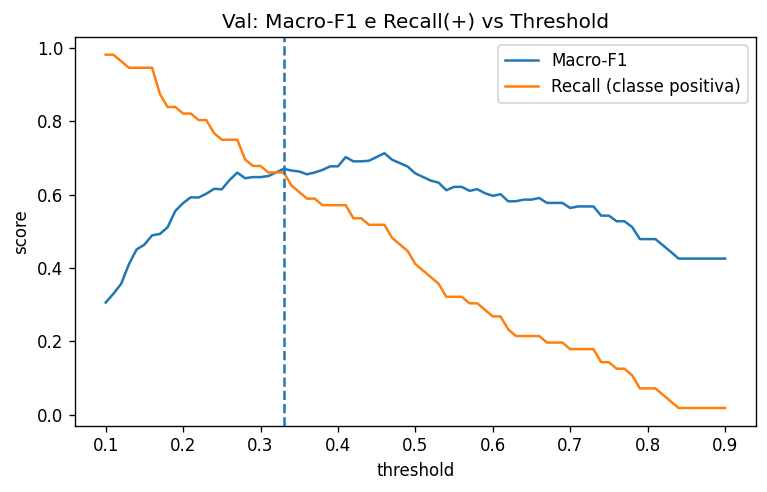

In [ ]:

y_val_bin  = (splits.val[LABEL_COL]==pos_label).astype(int).values
probs_val  = pipe.predict_proba(splits.val[TEXT_COL])[:, idx_pos]

best_t, best_score, best_stats = 0.5, -1.0, None
grid = np.linspace(0.1, 0.9, 81)

macro_hist = []
for t in grid:
    y_hat = (probs_val>=t).astype(int)
    p,r,f,s = precision_recall_fscore_support(
        y_val_bin, y_hat, average=None, labels=[0,1], zero_division=0)
    f_macro = (f[0]+f[1])/2.0
    macro_hist.append((t, f_macro, r[1]))
    if r[1] >= RECALL_FLOOR and f_macro > best_score:
        best_t, best_score = t, f_macro
        best_stats = {"precision": p.tolist(), "recall": r.tolist(), "f1": f.tolist(), "support": s.tolist()}

if best_score < 0:
    for t in grid:
        y_hat = (probs_val>=t).astype(int)
        p,r,f,s = precision_recall_fscore_support(
            y_val_bin, y_hat, average=None, labels=[0,1], zero_division=0)
        f_macro = (f[0]+f[1])/2.0
        if f_macro > best_score:
            best_t, best_score = t, f_macro
            best_stats = {"precision": p.tolist(), "recall": r.tolist(), "f1": f.tolist(), "support": s.tolist()}

print(f"Threshold escolhido: {best_t:.2f} | Val Macro-F1: {best_score:.4f} | Recall(minoria)≥{RECALL_FLOOR}")

mts = np.array(macro_hist)
plt.figure()
plt.plot(mts[:,0], mts[:,1], label="Macro-F1")
plt.plot(mts[:,0], mts[:,2], label="Recall (classe positiva)")
plt.axvline(best_t, linestyle="--")
plt.title("Val: Macro-F1 e Recall(+) vs Threshold")
plt.xlabel("threshold"); plt.ylabel("score"); plt.legend(); plt.tight_layout()
plt.show()


{
  "accuracy": 0.7401,
  "macro_f1": 0.7101,
  "weighted_f1": 0.7446
}
\n[VAL] accuracy: 0.6966 | macro_f1: 0.6706


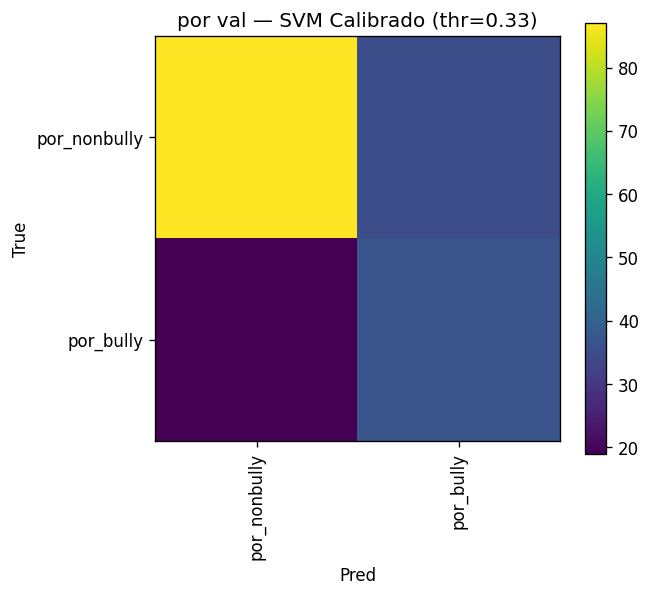

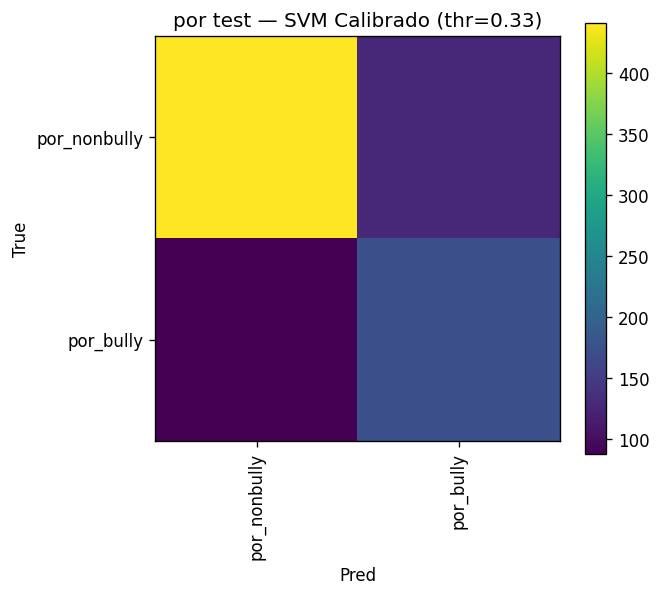

Artefatos salvos em: .


In [ ]:

probs_test      = pipe.predict_proba(splits.test[TEXT_COL])[:, idx_pos]
y_test_bin      = (splits.test[LABEL_COL]==pos_label).astype(int).values
y_hat_test_bin  = (probs_test>=best_t).astype(int)
y_hat_test_lbl  = np.where(y_hat_test_bin==1, pos_label, neg_label)

mets_test = compute_metrics(splits.test[LABEL_COL], y_hat_test_lbl)
print(json.dumps({k: (round(v,4) if isinstance(v,float) else v) for k,v in mets_test.items() if k!='report'}, indent=2))

y_hat_val_bin = (probs_val>=best_t).astype(int)
y_hat_val_lbl = np.where(y_hat_val_bin==1, pos_label, neg_label)
mets_val = compute_metrics(splits.val[LABEL_COL], y_hat_val_lbl)
print("\\n[VAL] accuracy:", round(mets_val["accuracy"],4), "| macro_f1:", round(mets_val["macro_f1"],4))

plot_confusion(splits.val[LABEL_COL],  y_hat_val_lbl,  labels_sorted_bin,
               title=f"{LANG} val — SVM Calibrado (thr={best_t:.2f})")
plot_confusion(splits.test[LABEL_COL], y_hat_test_lbl, labels_sorted_bin,
               title=f"{LANG} test — SVM Calibrado (thr={best_t:.2f})")

with open(OUT_DIR / f"{LANG}_test_metrics.json","w",encoding="utf-8") as f:
    json.dump(mets_test, f, indent=2, ensure_ascii=False)
with open(OUT_DIR / f"{LANG}_val_metrics.json","w",encoding="utf-8") as f:
    json.dump(mets_val, f, indent=2, ensure_ascii=False)

pd.DataFrame({
    "text": splits.test[TEXT_COL],
    "y_true": splits.test[LABEL_COL],
    "y_pred": y_hat_test_lbl,
    "proba_pos": probs_test
}).to_csv(OUT_DIR / f"{LANG}_test_predictions.csv", index=False)
print("Artefatos salvos em:", OUT_DIR)


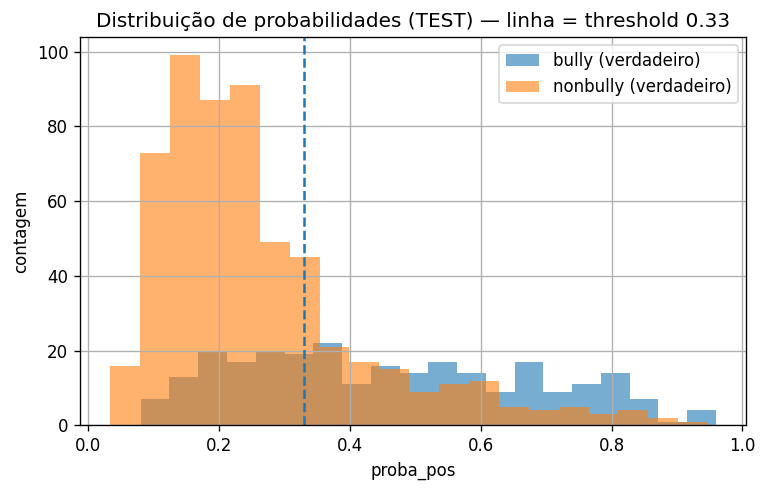

\nTop-3 FNs:
                                                                                                                                        text  proba_pos
     afinal, a privatização do ensino médio/superior brasileiro e o fim dos projetos sociais que ajudam milhões é o que vai levantar o país   0.080303
                                                                      ui nooooooofa que lindo fofa nosso galao e mara ne amiga rajkazblanks   0.080797
os bebés adoptados são c/ os telemóveis novos: qd os vamos buscar desesperamos se os deixamos cair. qd vemos 1 defeito,abrimos conta no olx   0.090017
\nTop-3 FPs:
                                                                                                                  text  proba_pos
                                                                                      eu só sigo sapatão e viado kkkk   0.947556
                                                                                                puta merda. qu

In [ ]:

pred_path = OUT_DIR / f"{LANG}_test_predictions.csv"
dfp = pd.read_csv(pred_path)

pos = pos_label
dfp["y_true_bin"] = (dfp["y_true"]==pos).astype(int)

plt.figure()
dfp[dfp.y_true_bin==1]["proba_pos"].hist(alpha=0.6, bins=20, label="bully (verdadeiro)")
dfp[dfp.y_true_bin==0]["proba_pos"].hist(alpha=0.6, bins=20, label="nonbully (verdadeiro)")
plt.axvline(best_t, linestyle="--")
plt.title(f"Distribuição de probabilidades (TEST) — linha = threshold {best_t:.2f}")
plt.xlabel("proba_pos"); plt.ylabel("contagem"); plt.legend(); plt.tight_layout()
plt.show()

fns = dfp[(dfp.y_true==pos)&(dfp.y_pred!=pos)].sort_values("proba_pos").head(3)[["text","proba_pos"]]

fps = dfp[(dfp.y_true!=pos)&(dfp.y_pred==pos)].sort_values("proba_pos", ascending=False).head(3)[["text","proba_pos"]]

print("\\nTop-3 FNs:\n", fns.to_string(index=False))
print("\\nTop-3 FPs:\n", fps.to_string(index=False))


## Conclusão (auto)

- Threshold escolhido pelo **VAL**: otimiza Macro-F1 com piso de *recall* para a minoria.
- O pipeline **word+char TF-IDF + LinearSVC calibrado** é leve e competitivo em PT ruidoso.
- Próximos passos sugeridos:
  1. *Ablation* (word-only vs char-only vs ambos)
  2. Regras leves para filtrar FPs “neutros”
  3. Comparativo rápido com um BERT PT (ex.: BERTimbau) e análise de custo/latência